# Project 4 - Team Holbrook Working


### Topic: Nutritional Sufficiency in Tanzanian Families with Children
We are exploring whether families with children (under 13 years old) meet nutritional requirements, and the nuances within this sufficiency or lack thereof (e.g. how does this vary between the rural and urban areas, number of children?) What policies can be implemented to assist families in meeting their nutritional requirements more effectively?

### Goals
* Develop a demand-nutrient model considering price, budget, and household factors.
* Identify nutritional challenges for families; establish policy goals.
* Design, simulate, and assess cost-effective policies.
* Analyze demographic, health, economic, and climate data; form food demand model.
* Examine long-term effects of nutritional changes and food demand in Tanzania.


### Table of Contents: 
* [(A) Choice of Dataset](#population)
* [(A) Estimate Demand System](#demand)
* [(A) Construct Nutrient System](#nutrient)
* [(A) Nutritional Adequacy of Food Demands¶](#adequacy)
* [(A) Policy Goal](#policy)

#### Setup



In [1]:
!pip install -r requirements.txt

In [2]:
import pandas as pd
import cfe.regression as rgsn
import warnings
warnings.filterwarnings('ignore')

Missing dependencies for OracleDemands.


## (A) Choice of Dataset<a class="anchor" id="population"></a>
We&rsquo;ll get data from two places.  First, basic data, including a food
 conversion table and recommended daily intakes table can be found in
 a google spreadsheet.


In [3]:
InputFiles = {'Expenditures':('1POplhyd44h-Zt8jMhXa2FGAzS051TPoLa2xMlmvVLU0','Expenditures'),
              'Prices':('1XaJJuVpHAJ2kK-wOg7CfdENc6XISYY_NKL0lK9wGEcU','Food Prices'),
              'HH Characteristics':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','HH Characteristics'),
              'FCT':('13cuZwMSDFtiDxUARUQc72kLj2QDv5gqPGbgjTijuUzc','For Use in Code'),
              'RDI':('1KS9270VK5mkFXalZPavxa85rHg3jiuLyL-oetUrf1m4','diet_minimums'),}

### Prices, FCT, RDI



In [4]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    return get_clean_df(df)

def get_clean_df(df):
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]
    
    return df
    

# Get prices
p = pd.read_pickle('pickles/Tanzania_prices_clean.pickle') # pickle of prices, where the labels were renamed to match FCT
p = p.rename({'': 'units'},axis=1) #Rename units column
p = p.loc[p['units']!='piece'] #Only use kg units..
p = pd.DataFrame(np.vstack([p.columns, p])) # Make t column header as a row
p = p.drop(1, axis=1) # Drop units column
p = p.T #Transpose p
p.columns = p.iloc[0] #Make first row into column header
p = p.drop(0, axis=0) #Drop first row (current column header)
p = p.reset_index(drop=True)

p = get_clean_df(p)

p = p.drop('j',axis=1)

if 'm' not in p.columns:  # Supply "market" indicator if missing
    p['m'] = 1

p = p.set_index(['t','m'])
p.columns.name = 'j'

p = p.apply(lambda x: pd.to_numeric(x,errors='coerce'))
p = p.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

fct = fct.rename(columns={"Item name": "j"})

fct = fct.set_index('j')
fct.columns.name = 'n'
fct = fct.drop('Value',axis=1)

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))
fct = fct.dropna(how='all',axis=0)

################## RDI, if available (consider using US) ##################### ##
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])

rdi = rdi.rename(columns={"Nutrition": "n"})
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


### Pre-estimated Demand Systems
An instance `r` of `cfe.Regression` was saved as a pickle from Project 3. We will load and use this demand system previously estimated for Tanzania. We have renamed food labels to match one another as well as filtered the regression results for families with children and without. You can view how we did this in `Clean_Dataset.ipynb` and `Tanzania_Regression.ipynb`.



In [5]:
r_children = rgsn.read_pickle('pickles/Tanzania_results_children.pickle')
r_nochildren = rgsn.read_pickle('pickles/Tanzania_results_nochildren.pickle')

### Reference Prices



We chose a particular year 2010-11 for our reference prices, because that is the median year available in our Tanzanian 2008-2014 dataset, and found the average prices across markets. 

#### Children

In [6]:
# These are prices per kilogram:
pbar_children = p.xs('2010-11',level='t').mean()

pbar_children = pbar_children[r_children.beta.index] # Only use prices for goods we can estimate

#### No Children

In [7]:
pbar_nochildren = p.xs('2010-11',level='t').mean()

pbar_nochildren = pbar_nochildren[r_nochildren.beta.index] # Only use prices for goods we can estimate

### Budgets
Get food budget for all households, then find median budget:



#### Children

In [8]:
import numpy as np

xhat_children = r_children.predicted_expenditures()

# Total food expenditures per household
xbar_children = xhat_children.groupby(['i','t','m']).sum()

# Reference budget
xref_children = xbar_children.quantile(0.5)  # Household at 0.5 quantile is median

#### No Children

In [9]:
xhat_nochildren = r_nochildren.predicted_expenditures()

# Total food expenditures per household
xbar_nochildren = xhat_nochildren.groupby(['i','t','m']).sum()

# Reference budget
xref_nochildren = xbar_nochildren.quantile(0.5)  # Household at 0.5 quantile is median

### Food Quantities
Get quantities of food by dividing expenditures by prices:

#### Children

In [10]:
qhat_children = (xhat_children.unstack('j')/pbar_children).dropna(how='all')

# Drop missing columns
qhat_children = qhat_children.loc[:,qhat_children.count()>0]

qhat_children

j                             Beef including minced sausage  Bread, white   
i     t       m                                                             
2     2014-15 Mainland Rural                       1.006731      1.109569  \
4     2012-13 Mainland Rural                       0.170262      0.297871   
      2014-15 Mainland Rural                       0.769420      0.963211   
5     2012-13 Mainland Rural                       1.563294      2.375664   
      2014-15 Mainland Rural                       2.274299      2.666136   
...                                                     ...           ...   
14974 2014-15 Mainland Rural                       0.733923      0.950251   
14979 2014-15 Mainland Rural                       2.208696      2.635804   
14980 2014-15 Mainland Rural                       1.187379      1.475910   
14981 2014-15 Mainland Rural                       1.610509      2.386478   
14983 2014-15 Mainland Rural                       1.227274      1.409025   

j                             Cassava Fresh, raw  Chicken and other poultry   
i     t       m                                                               
2     2014-15 Mainland Rural            3.507788                   1.464378  \
4     2012-13 Mainland Rural            1.286084                   0.266445   
      2014-15 Mainland Rural            2.564738                   1.282314   
5     2012-13 Mainland Rural            6.504772                   1.575575   
      2014-15 Mainland Rural            6.730535                   2.630180   
...                                          ...                        ...   
14974 2014-15 Mainland Rural            3.169087                   1.241343   
14979 2014-15 Mainland Rural            5.946187                   2.737102   
14980 2014-15 Mainland Rural            3.462957                   1.649535   
14981 2014-15 Mainland Rural            6.192782                   2.396422   
14983 2014-15 Mainland Rural            4.116915                   1.797957   

j                             Coconuts (mature/immature)   
i     t       m                                            
2     2014-15 Mainland Rural                    1.963924  \
4     2012-13 Mainland Rural                    0.567681   
      2014-15 Mainland Rural                    1.681164   
5     2012-13 Mainland Rural                    2.457452   
      2014-15 Mainland Rural                    2.974734   
...                                                  ...   
14974 2014-15 Mainland Rural                    1.521758   
14979 2014-15 Mainland Rural                    3.441564   
14980 2014-15 Mainland Rural                    2.211176   
14981 2014-15 Mainland Rural                    3.246989   
14983 2014-15 Mainland Rural                    2.117002   

j                             Cooking bananas (/Plantains)   
i     t       m                                              
2     2014-15 Mainland Rural                      2.735230  \
4     2012-13 Mainland Rural                      0.754428   
      2014-15 Mainland Rural                      2.344834   
5     2012-13 Mainland Rural                      5.250936   
      2014-15 Mainland Rural                      5.533575   
...                                                    ...   
14974 2014-15 Mainland Rural                      2.059927   
14979 2014-15 Mainland Rural                      5.701203   
14980 2014-15 Mainland Rural                      3.202145   
14981 2014-15 Mainland Rural                      4.863479   
14983 2014-15 Mainland Rural                      3.225486   

j                             Cooking oil (vegetable oil)   
i     t       m                                             
2     2014-15 Mainland Rural                     0.676867  \
4     2012-13 Mainland Rural                     0.132237   
      2014-15 Mainland Rural                     0.486473   
5     2012-13 Mainland Rural                     1.120998   
      2014-15 Ma

#### No Children

In [11]:
qhat_nochildren = (xhat_nochildren.unstack('j')/pbar_nochildren).dropna(how='all')

# Drop missing columns
qhat_nochildren = qhat_nochildren.loc[:,qhat_nochildren.count()>0]

qhat_nochildren

j                                   Beef including minced sausage   
i     t       m                                                     
1     2012-13 Mainland Rural                             0.608954  \
      2014-15 Mainland Rural                             0.774432   
14    2012-13 Mainland Rural                             0.827658   
18    2012-13 Mainland Rural                             0.435962   
46    2012-13 Dar Es Salaam                              0.822198   
...                                                           ...   
14530 2014-15 Mainland Rural                             0.515611   
14539 2014-15 Mainland Rural                             0.351691   
14572 2014-15 Mainland Other Urban                       1.393290   
14755 2014-15 Mainland Rural                             0.818038   
14776 2014-15 Mainland Other Urban                       1.928167   

j                                   Bread, white  Cooking oil (vegetable oil)   
i     t       m                                                                 
1     2012-13 Mainland Rural            0.497109                     0.381679  \
      2014-15 Mainland Rural            1.177541                     0.519698   
14    2012-13 Mainland Rural            0.900180                     0.569563   
18    2012-13 Mainland Rural            0.444421                     0.332372   
46    2012-13 Dar Es Salaam             1.049182                     0.493096   
...                                          ...                          ...   
14530 2014-15 Mainland Rural            0.715140                     0.363561   
14539 2014-15 Mainland Rural            0.413168                     0.231722   
14572 2014-15 Mainland Other Urban      2.121049                     0.741386   
14755 2014-15 Mainland Rural            1.540137                     0.625583   
14776 2014-15 Mainland Other Urban      2.572970                     1.058707   

j                                   Fresh milk   
i     t       m                                  
1     2012-13 Mainland Rural          0.590569  \
      2014-15 Mainland Rural          2.578832   
14    2012-13 Mainland Rural          1.298832   
18    2012-13 Mainland Rural          0.371837   
46    2012-13 Dar Es Salaam           1.979860   
...                                        ...   
14530 2014-15 Mainland Rural          2.080622   
14539 2014-15 Mainland Rural          1.133169   
14572 2014-15 Mainland Other Urban    2.470104   
14755 2014-15 Mainland Rural          1.655724   
14776 2014-15 Mainland Other Urban    3.245717   

j                                   Irish potatoes, cooked (English)   
i     t       m                                                        
1     2012-13 Mainland Rural                                0.680879  \
      2014-15 Mainland Rural                                1.030320   
14    2012-13 Mainland Rural                                1.308562   
18    2012-13 Mainland Rural                                0.652994   
46    2012-13 Dar Es Salaam                                 1.268104   
...                                                              ...   
14530 2014-15 Mainland Rural                                1.093982   
14539 2014-15 Mainland Rural                                0.589211   
14572 2014-15 Mainland Other Urban                          1.160203   
14755 2014-15 Mainland Rural                                0.974844   
14776 2014-15 Mainland Other Urban                          1.660135   

j                                   Lentil, cooked / Peas (/Beans, lentils and other pulses)   
i     t       m                                                                                
1     2012-13 Mainland Rural                                                 0.984188         \
      2014-15 Mainland Rural                                                 1.710162          
14    2012-13 Mainland Rural                                                

Finally, define a function to change a single price in the vector $p$:



In [12]:
def my_prices(p0,p,j='Maize (Flour, dry)'):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

### (A) Estimate Demand System<a class="anchor" id="demand"></a>

### Engel Curves



#### Children

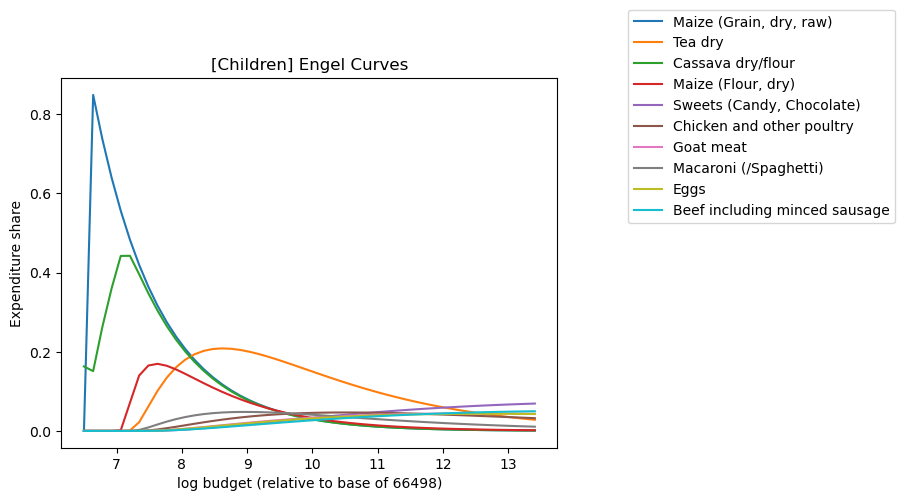

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

scale = np.geomspace(.01,10,50)

children_expenditures = [r_children.expenditures(s*xref_children,pbar_children)/(s*xref_children) for s in scale]
children_expd_df = pd.concat(children_expenditures,axis=1).T
children_expd_df.mean().sort_values(ascending=False)[:10].index
children_expd_df_10 = children_expd_df[children_expd_df.mean().sort_values(ascending=False)[:10].index]

ax.plot(np.log(scale*xref_children),children_expd_df_10)
ax.set_xlabel(f'log budget (relative to base of {xref_children:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('[Children] Engel Curves')
ax.legend(children_expd_df_10.columns, loc="center left",
    bbox_to_anchor=(1, 0.8),
    bbox_transform=fig.transFigure)

#### No Children

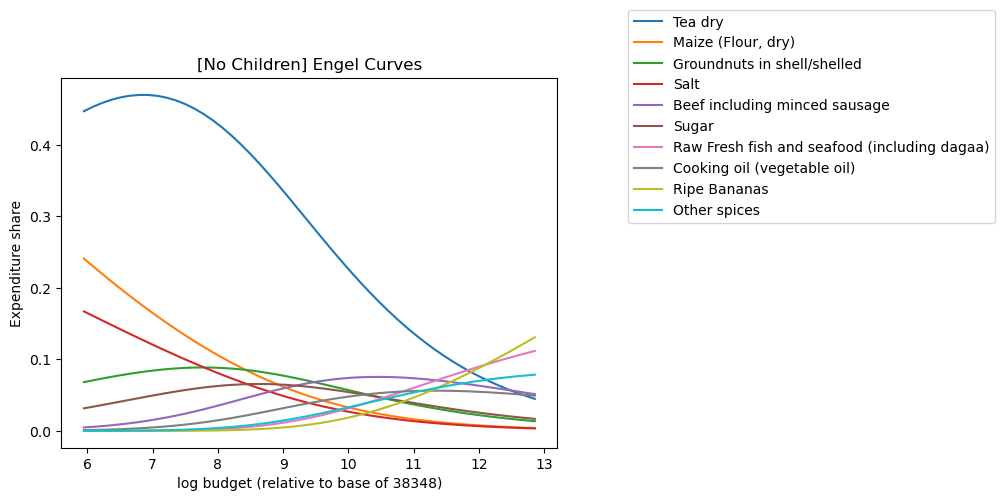

In [14]:
fig,ax = plt.subplots()

scale = np.geomspace(.01,10,50)

nochildren_expenditures = [r_nochildren.expenditures(s*xref_nochildren,pbar_nochildren)/(s*xref_nochildren) for s in scale]
nochildren_expd_df = pd.concat(nochildren_expenditures,axis=1).T
nochildren_expd_df.mean().sort_values(ascending=False)[:10].index
nochildren_expd_df_10 = nochildren_expd_df[nochildren_expd_df.mean().sort_values(ascending=False)[:10].index]

ax.plot(np.log(scale*xref_nochildren),nochildren_expd_df_10)
ax.set_xlabel(f'log budget (relative to base of {xref_nochildren:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('[No Children] Engel Curves')
ax.legend(nochildren_expd_df_10.columns, loc="center left",
    bbox_to_anchor=(1, 0.8),
    bbox_transform=fig.transFigure)

### (A) Construct Nutrient System<a class="anchor" id="nutrient"></a>



We need the index of the Food Conversion Table (FCT) to match up with
 the index of the vector of quantities demanded.   To manage this we
 make use of the `align` method for `pd.DataFrames`. After, the rows of `fct0` and `c0` match, we can obtain nutritional
 outcomes from the inner (or dot, or matrix) product of the transposed
 `fct0` and `c0`:





#### Children

In [15]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0_children,c0_children = fct.align(qhat_children.T,axis=0,join='inner')

# The @ operator means matrix multiply
N_children = fct0_children.T@c0_children

N_children  #NB: Tanzania quantities are for previous 7 days

i                                       2              4                      
t                                     2014-15        2012-13        2014-15   
m                              Mainland Rural Mainland Rural Mainland Rural   
n                                                                             
Energy                            8762.214424    4262.687055    8311.337272  \
Protein                            302.400763     110.753368     265.367108   
Vitamin A, RAE                    5328.606096    1416.917394    3929.821503   
Vitamin D (calciferol)              17.030770       2.604546      12.735233   
Vitamin E (alpha-tocopherol)        45.188215      16.061620      37.842623   
Vitamin C, total ascorbic acid     302.039307      73.914531     220.877731   
Vitamin B-6                         13.512117       4.474358      11.303576   
Vitamin B-12                        34.443096       6.160051      24.683861   
Calcium, Ca                       1941.132168     565.415865    1603.813075   
Magnesium, Mg                     1827.525810    1100.339843    1824.139721   
Iron, Fe                            62.391134      34.035965      62.193790   
Zinc, Zn                            37.106618      18.749935      35.987781   

i                                       5                             8       
t                                     2012-13        2014-15        2012-13   
m                              Mainland Rural Mainland Rural Mainland Rural   
n                                                                             
Energy                           17508.823806   19007.305569    9103.202418  \
Protein                            537.424633     638.091285     268.876439   
Vitamin A, RAE                    8054.233123    9136.196377    3958.864140   
Vitamin D (calciferol)              21.883198      29.577096      11.016122   
Vitamin E (alpha-tocopherol)        75.776828      89.379189      37.759584   
Vitamin C, total ascorbic acid     489.041741     583.950044     234.010907   
Vitamin B-6                         23.376743      28.400902      11.656725   
Vitamin B-12                        50.964274      67.292329      24.914014   
Calcium, Ca                       3352.932342    3834.541718    1604.630405   
Magnesium, Mg                     3945.212297    4066.213619    2082.144737   
Iron, Fe                           130.095809     139.413641      67.011667   
Zinc, Zn                            75.896148      82.937736      38.828226   

i                                                      9              11      
t                                     2014-15        2012-13        2012-13   
m                              Mainland Rural Mainland Rural Mainland Rural   
n                                                                             
Energy                           10488.227206    6201.738953    5122.555214  \
Protein                            326.501775     167.350224     133.781902   
Vitamin A, RAE                    4690.196229    2637.185966    1663.438837   
Vitamin D (calciferol)              15.470065       4.322166       3.245752   
Vitamin E (alpha-tocopherol)        45.738897      25.650719      19.163000   
Vitamin C, total ascorbic acid     274.507054     128.608221      86.674692   
Vitamin B-6                         14.174679       6.949507       5.400226   
Vitamin B-12                        31.376350      10.321523       7.452811   
Calcium, Ca                       1941.144588     863.569299     679.437840   
Magnesium, Mg                     2330.188958    1596.002683    1323.309322   
Iron, Fe                            78.209875      50.307910      41.110017   
Zinc, Zn                            45.325074      27.728245      22.665299   

i                                              ...                14966   
t                                     2014-15  ...              2014-15   
m                              Mainland Rural  ... Main

#### No Children

In [16]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0_nochildren,c0_nochildren = fct.align(qhat_nochildren.T,axis=0,join='inner')

# The @ operator means matrix multiply
N_nochildren = fct0_nochildren.T@c0_nochildren

N_nochildren  #NB: Tanzania quantities are for previous 7 days

i                                       1                             14      
t                                     2012-13        2014-15        2012-13   
m                              Mainland Rural Mainland Rural Mainland Rural   
n                                                                             
Energy                            5838.783693    8162.052161    5122.284851  \
Protein                            141.664546     208.378042     136.190241   
Vitamin A, RAE                     964.420900    1841.354670    1774.096632   
Vitamin D (calciferol)               4.587340      10.568017       8.472763   
Vitamin E (alpha-tocopherol)        16.592566      22.630846      18.774307   
Vitamin C, total ascorbic acid      84.919941     157.925602     126.361725   
Vitamin B-6                          5.096363       7.432616       5.040068   
Vitamin B-12                         1.813747       3.471690       2.868754   
Calcium, Ca                        423.959646     896.750800     653.013952   
Magnesium, Mg                     1666.805907    2261.947145    1380.315052   
Iron, Fe                            51.536370      70.474399      43.610846   
Zinc, Zn                            28.637083      39.362333      24.737848   

i                                       18            46             65      
t                                     2012-13       2012-13        2012-13   
m                              Mainland Rural Dar Es Salaam Mainland Rural   
n                                                                            
Energy                            2626.118622   4375.369472    3237.312877  \
Protein                             66.984901    128.486852      77.648401   
Vitamin A, RAE                     638.662167   1514.399387     481.918800   
Vitamin D (calciferol)               3.544563     13.505027       2.036549   
Vitamin E (alpha-tocopherol)         9.548639     15.125227       9.763516   
Vitamin C, total ascorbic acid      48.628638    128.169475      38.237142   
Vitamin B-6                          2.441748      4.296959       2.819234   
Vitamin B-12                         1.301981      3.592080       0.984467   
Calcium, Ca                        239.339383    689.102474     216.297076   
Magnesium, Mg                      699.156199   1013.186029     934.397301   
Iron, Fe                            21.732774     30.979736      28.604640   
Zinc, Zn                            12.539242     19.916511      15.837979   

i                                             66                   69      
t                                           2012-13              2012-13   
m                              Mainland Other Urban Mainland Other Urban   
n                                                                          
Energy                                  5750.852645         10142.177813  \
Protein                                  172.357857           281.424499   
Vitamin A, RAE                          1802.090621          2485.228149   
Vitamin D (calciferol)                    18.012920            21.685936   
Vitamin E (alpha-tocopherol)              26.907766            38.424832   
Vitamin C, total ascorbic acid           203.427540           330.073119   
Vitamin B-6                                6.453729            10.669977   
Vitamin B-12                               5.445625             7.042846   
Calcium, Ca                              927.101234          1379.220477   
Magnesium, Mg                           1367.704565          2531.933828   
Iron, Fe                                  41.742773            79.693276   
Zinc, Zn                                  26.713654            48.441942   

i                                             75                   78     ...   
t                                           2012-13              2012-13  ...   
m                              Mainland Other Urban Mainland Other Urban  ...   
n                         

Of course, since we can compute the nutritional content of a vector of
 consumption goods `c0`, we can also use our demand functions to
 compute nutrition as a *function* of prices and budget.



In [17]:
def nutrient_demand(r,x,p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

### Budget Imapct on Nutrient Outcomes 

With this `nutrient_demand` function in hand, we can see how nutrient
 outcomes vary with budget, given prices.

#### Children

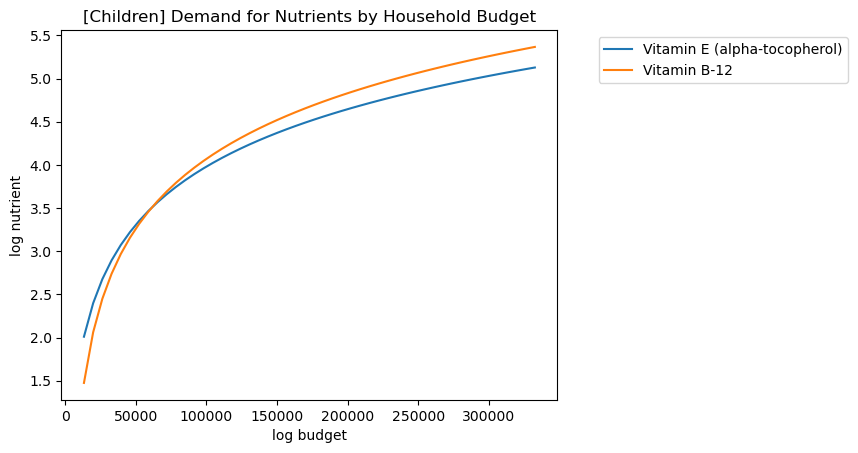

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

X_children = np.linspace(xref_children/5,xref_children*5,50)

#UseNutrients = list(N_children.index)
UseNutrients = ['Vitamin E (alpha-tocopherol)','Vitamin B-12']

df = pd.concat({myx:np.log(nutrient_demand(r_children,myx,pbar_children))[UseNutrients] for myx in X_children},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')
ax.set_title("[Children] Demand for Nutrients by Household Budget")
ax.legend(UseNutrients, loc='upper right',bbox_to_anchor=(1.6, 1))

#### No Children

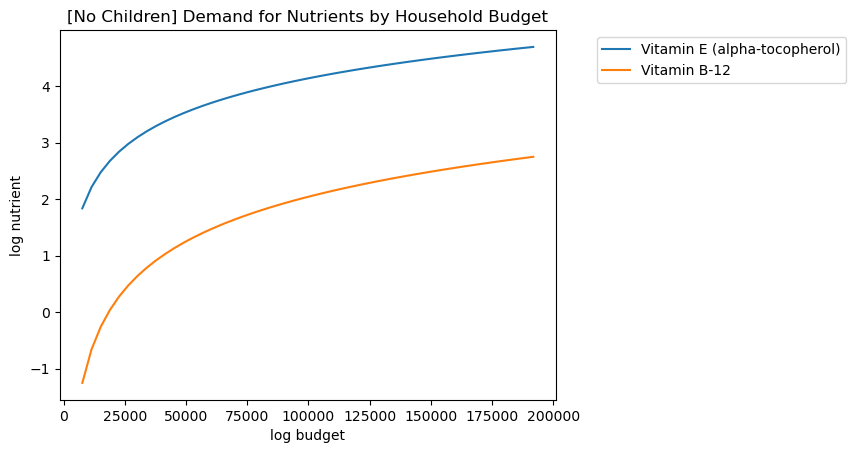

In [19]:
X_nochildren = np.linspace(xref_nochildren/5,xref_nochildren*5,50)

#UseNutrients = list(N_nochildren.index)
UseNutrients = ['Vitamin E (alpha-tocopherol)','Vitamin B-12']

df = pd.concat({myx:np.log(nutrient_demand(r_nochildren,myx,pbar_nochildren))[UseNutrients] for myx in X_nochildren},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')
ax.set_title("[No Children] Demand for Nutrients by Household Budget")
ax.legend(UseNutrients, loc='upper right',bbox_to_anchor=(1.6, 1))

### Price Impact on Nutrition Outcomes

#### Children

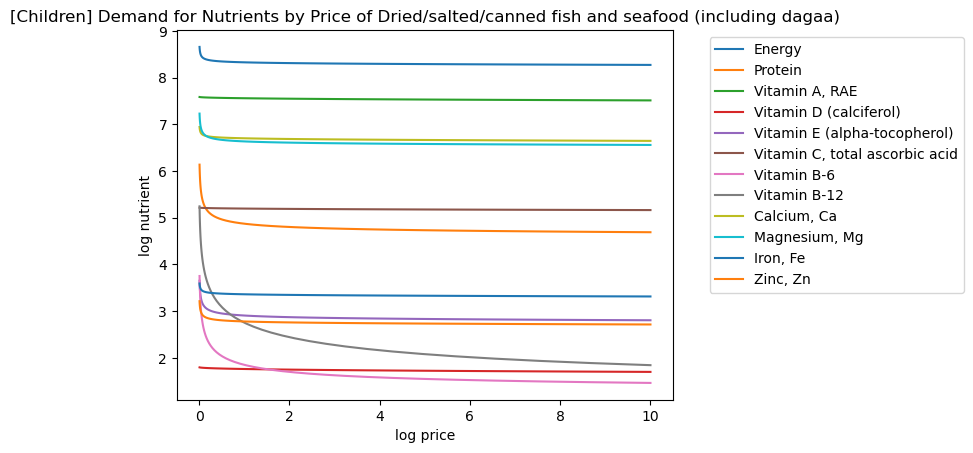

In [20]:
USE_GOOD = 'Dried/salted/canned fish and seafood (including dagaa)'
UseNutrients = list(N_nochildren.index)

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(r_children, xref_children/2,my_prices(pbar_children[USE_GOOD]*s,pbar_children,j=USE_GOOD)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')
ax.set_title("[Children] Demand for Nutrients by Price of %s" % USE_GOOD)
ax.legend(UseNutrients, loc='upper right',bbox_to_anchor=(1.6, 1))

### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For the average household in our data, the number of
different kinds of people can be computed by averaging over households:



#### Children

In [21]:
# In first round, averaged over households and villages
dbar_children = r_children.d.mean().iloc[:-2]

#### No Children

In [22]:
dbar_nochildren = r_nochildren.d.mean().iloc[:-2]

Now, the inner/dot/matrix product between `dbar` and the `rdi`
DataFrame of requirements will give us minimum requirements for the
average household:



In [23]:
rdi = rdi.drop("Source",axis=1)
rdi["Males 00-03"] = rdi["C 1-3"]
rdi_map = {'C 1-3': 'Females 00-03', 'F 4-8': 'Females 04-08', 'F 9-13': 'Females 09-13', 'F 14-18': 'Females 14-18', 
 'F 19-30': 'Females 19-30', 'F 31-50': 'Females 31-50', 'F 51+': 'Females 51-99', 
 'M 4-8' : 'Males 04-08', 'M 9-13' : 'Males 09-13', 'M 14-18': 'Males 14-18', 'M 19-30': 'Males 19-30', 
 'M 31-50': 'Males 31-50', 'M 51+' : 'Males 51-99'}

In [24]:
rdi = rdi.rename(columns = rdi_map)
rdi

k,Females 00-03,Females 04-08,Males 04-08,Females 09-13,Males 09-13,Females 14-18,Males 14-18,Females 19-30,Males 19-30,Females 31-50,Males 31-50,Females 51-99,Males 51-99,Males 00-03
n,,,,,,,,,,,,,,
Energy,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0,1000.0
Protein,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0,13.0
"Fiber, total dietary",14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0,14.0
"Folate, DFE",150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,150.0
"Calcium, Ca",700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0,700.0
"Carbohydrate, by difference",130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0
"Iron, Fe",7.0,10.0,10.0,8.0,8.0,15.0,11.0,18.0,8.0,18.0,8.0,8.0,8.0,7.0
"Magnesium, Mg",80.0,130.0,130.0,240.0,240.0,360.0,410.0,310.0,400.0,320.0,420.0,320.0,420.0,80.0
Niacin,6.0,8.0,8.0,12.0,12.0,14.0,16.0,14.0,16.0,14.0,16.0,14.0,16.0,6.0


In [30]:
# This matrix product gives minimum nutrient requirements for
# the average household
hh_rdi = rdi.replace('',0)@dbar_children
hh_rdi

n
Energy                            12200.879270
Protein                             268.353906
Fiber, total dietary                170.812310
Folate, DFE                        2266.985120
Calcium, Ca                        7486.033142
Carbohydrate, by difference         919.935746
Iron, Fe                             75.753635
Magnesium, Mg                      1924.721001
Niacin                               86.517078
Phosphorus, P                      5642.561718
Potassium, K                      30482.871153
Riboflavin                            6.774704
Thiamin                               6.589753
Vitamin A, RAE                     4510.804870
Vitamin B-12                         13.601911
Vitamin B-6                           7.482093
Vitamin C, total ascorbic acid      402.363882
Vitamin E (alpha-tocopherol)         84.501015
Vitamin K (phylloquinone)           536.724721
Zinc, Zn                             54.720494
dtype: float64

In [26]:
# This matrix product gives minimum nutrient requirements for
# the average household
hh_rdi = rdi.replace('',0)@dbar_nochildren
hh_rdi

n
Energy                             8823.018868
Protein                             219.894340
Fiber, total dietary                123.522264
Folate, DFE                        1735.849057
Calcium, Ca                        4743.773585
Carbohydrate, by difference         564.150943
Iron, Fe                             50.460377
Magnesium, Mg                      1600.264151
Niacin                               65.230189
Phosphorus, P                      3577.358491
Potassium, K                      20396.226415
Riboflavin                            5.175660
Thiamin                               4.951887
Vitamin A, RAE                     3485.283019
Vitamin B-12                         10.415094
Vitamin B-6                           5.879434
Vitamin C, total ascorbic acid      346.594340
Vitamin E (alpha-tocopherol)         65.094340
Vitamin K (phylloquinone)           427.188679
Zinc, Zn                             41.884906
dtype: float64

## (A) Nutritional Adequacy of Food Demands<a class="anchor" id="adequacy"></a>



Since we can trace out demands for nutrients as a function of $(x,p)$,
and we&rsquo;ve computed minimum nutritional requirements for the average
household, we can *normalize* nutritional intake to check the adequacy
of diet for a household with counts of different kinds of people given by `z`.



In [31]:
def nutrient_adequacy_ratio(r,x,p,d,rdi=rdi,days=7):
    hh_rdi = rdi.replace('',0)@d*days

    return nutrient_demand(r,x,p)/hh_rdi

In terms of normalized nutrients, any household with more than one
unit of any given nutrient (or zero in logs) will be consuming a
minimally adequate level of the nutrient; below this level there&rsquo;s
clearly nutritional inadequacy.  For this reason the ratio of
actual nutrients to required nutrients is termed the &ldquo;nutrient
adequacy ratio,&rdquo; or NAR.



#### Children

<IPython.core.display.Javascript object>


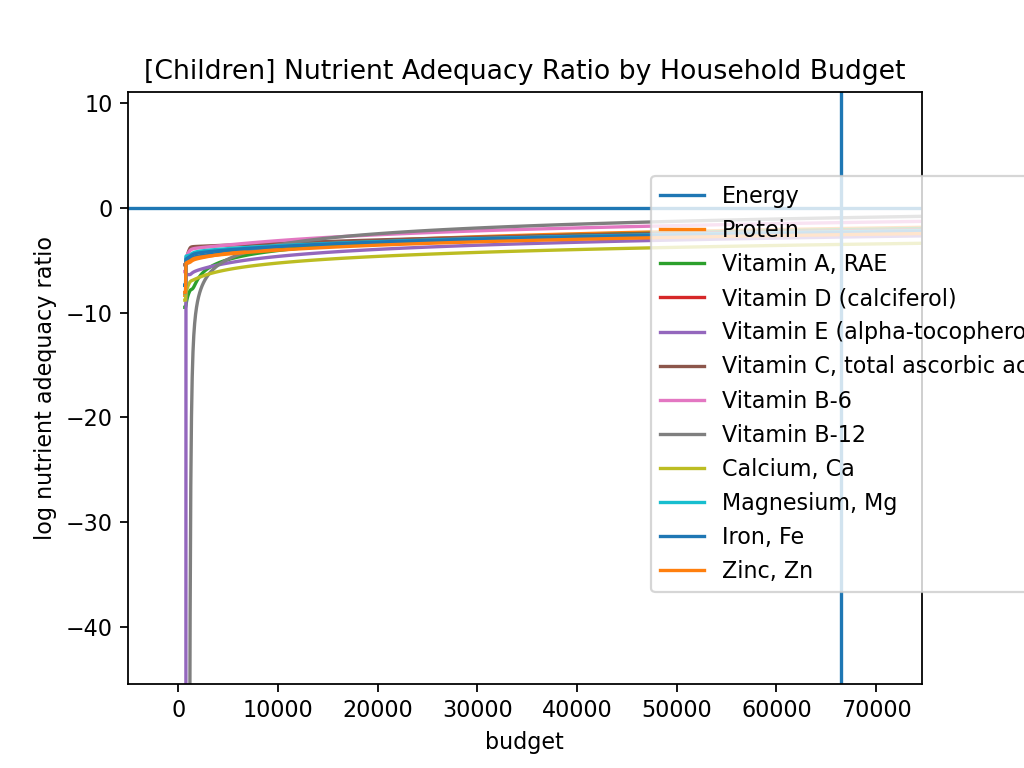

In [33]:
%matplotlib notebook
X_children = np.geomspace(.01*xref_children,2*xref_children,100)

UseNutrients = list(N_nochildren.index)
pd.DataFrame({x:np.log(nutrient_adequacy_ratio(r_children,x,pbar_children,dbar_children))[UseNutrients] for x in X_children}).T.plot()
plt.legend(UseNutrients, loc="center left",
    bbox_to_anchor=(1, 0.8),
    bbox_transform=fig.transFigure)

plt.xlabel('budget')
plt.ylabel('log nutrient adequacy ratio')
plt.title("[Children] Nutrient Adequacy Ratio by Household Budget")
plt.axhline(0)
plt.axvline(xref_children)

#### No Children

<IPython.core.display.Javascript object>


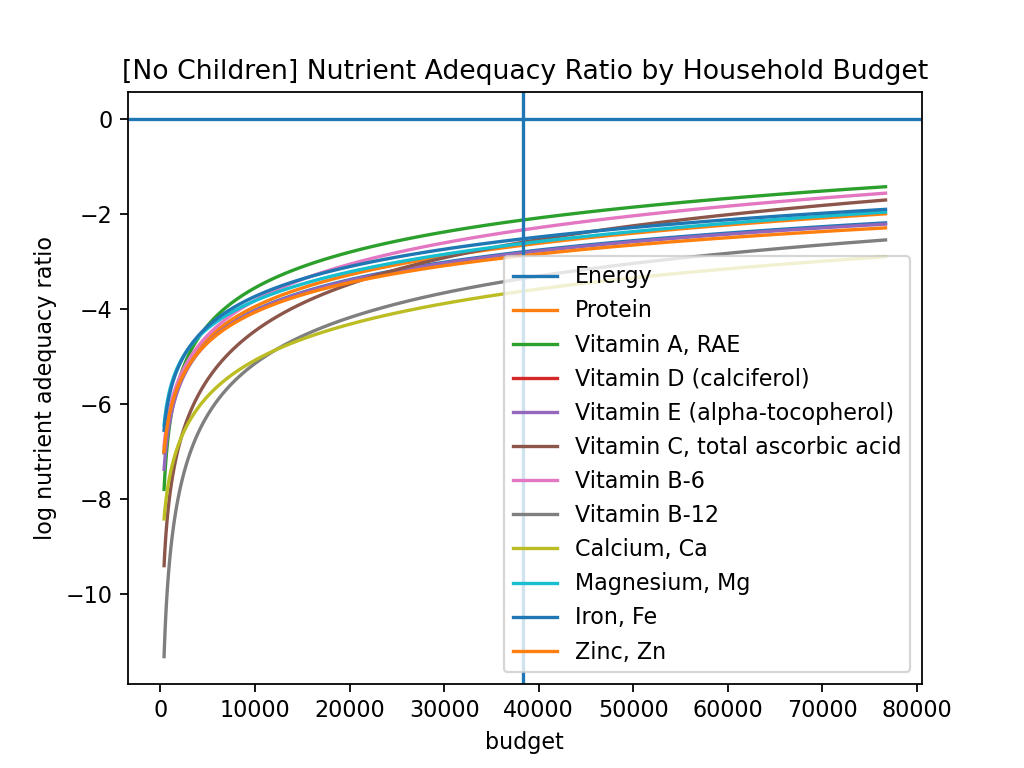

In [34]:
X_nochildren = np.geomspace(.01*xref_nochildren,2*xref_nochildren,100)

pd.DataFrame({x:np.log(nutrient_adequacy_ratio(r_nochildren,x,pbar_nochildren,dbar_nochildren))[UseNutrients] for x in X_nochildren}).T.plot()
plt.legend(UseNutrients)
plt.xlabel('budget')
plt.ylabel('log nutrient adequacy ratio')
plt.title("[No Children] Nutrient Adequacy Ratio by Household Budget")
plt.axhline(0)
plt.axvline(xref_nochildren)

### Identifying Foods with Vitamin E & Vitamin B-12

In [35]:
fct_e = fct.loc[(fct["Vitamin E (alpha-tocopherol)"] > 0)]

In [36]:
fct_e.sort_values(by="Vitamin E (alpha-tocopherol)", ascending = False)

n,Energy,Protein,"Vitamin A, RAE",Vitamin D (calciferol),Vitamin E (alpha-tocopherol),"Vitamin C, total ascorbic acid",Vitamin B-6,Vitamin B-12,"Calcium, Ca","Magnesium, Mg","Iron, Fe","Zinc, Zn"
j,,,,,,,,,,,,
Cashew (Almonds and other nuts),589.0,20.0,0.0,0.0,24.0,1.0,0.1,0.0,266.0,296.0,3.7,2.9
Groundnuts in shell/shelled,567.0,25.8,0.0,0.0,9.0,0.0,0.3,0.0,92.0,168.0,4.6,3.3
"Irish potatoes, cooked (English)",93.0,2.0,0.0,0.0,6.7,18.6,0.7,0.0,5.0,25.0,0.4,0.3
Yams/cocoyams raw,97.0,2.1,0.0,0.0,5.0,12.0,0.2,0.0,8.0,26.0,0.8,0.5
"Sweet potatoes, fresh AP",74.0,1.2,1056.0,0.0,4.0,18.0,0.2,0.0,20.0,14.0,0.4,0.2
Dried/salted/canned fish and seafood (including dagaa),309.0,66.4,0.0,0.0,4.0,0.0,7.3,35.0,41.0,122.0,1.4,1.7
Butter refined - ghee,876.0,0.3,925.0,2.0,3.0,0.0,0.0,0.0,8.0,1.0,0.1,0.0
Sunflower seed / Seeds and products from nuts/seeds (excl. cooking oil),588.0,26.4,7.0,0.0,2.0,0.0,0.2,0.0,131.0,347.0,7.8,10.3
Eggs,278.0,19.2,810.0,8.0,2.0,0.0,0.4,8.1,96.0,26.0,5.9,2.1


In [37]:
fct_e_b12 = fct.loc[(fct["Vitamin E (alpha-tocopherol)"] > 0) & (fct["Vitamin B-12"] > 0)]

In [38]:
fct_e_b12

n,Energy,Protein,"Vitamin A, RAE",Vitamin D (calciferol),Vitamin E (alpha-tocopherol),"Vitamin C, total ascorbic acid",Vitamin B-6,Vitamin B-12,"Calcium, Ca","Magnesium, Mg","Iron, Fe","Zinc, Zn"
j,,,,,,,,,,,,
Cake,320.0,4.7,34.0,0.0,1.0,0.0,0.0,0.2,38.0,9.0,0.4,0.4
Eggs,278.0,19.2,810.0,8.0,2.0,0.0,0.4,8.1,96.0,26.0,5.9,2.1
Raw Fresh fish and seafood (including dagaa),112.0,21.4,43.0,12.0,1.0,0.0,0.3,1.1,48.0,86.0,0.9,0.4
Dried/salted/canned fish and seafood (including dagaa),309.0,66.4,0.0,0.0,4.0,0.0,7.3,35.0,41.0,122.0,1.4,1.7
Fresh milk,60.0,3.2,28.0,0.0,0.1,0.0,0.0,0.4,115.0,12.0,0.0,0.0
Cream cheese (milk products),349.0,7.6,366.0,0.0,0.3,0.0,0.0,0.4,80.0,6.0,1.2,0.5


### Nutritional Adequacy varying the price of a single good

As before, we can also vary relative prices.  Here we trace out
nutritional adequacy varying the price of a single good. We chose to focus on `Dried/salted/canned fish and seafood (including dagaa) ` since it is the food that contains the most Vitamin E & Vitamin B-12, which is lacking in households with children.



#### Children

Text(0.5, 1.0, '[Children] Vitamin E Nutrient Adequacy Ratio by Price of Groundnuts in shell/shelled')

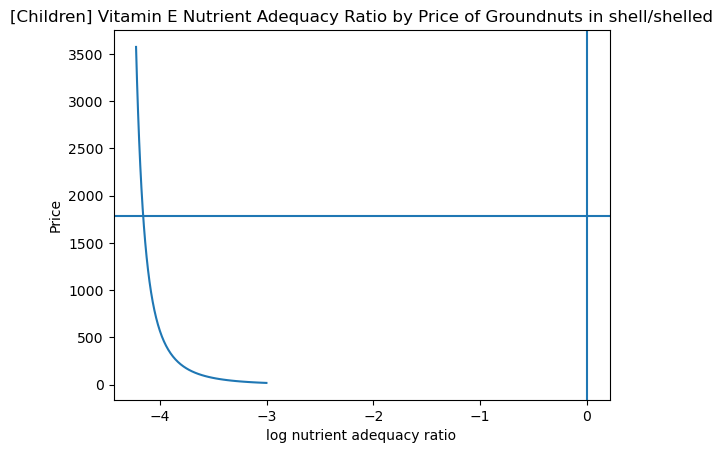

In [41]:
scale = np.geomspace(.01,2,50)

USE_GOOD = 'Groundnuts in shell/shelled'
ndf = pd.DataFrame({s*pbar_children[USE_GOOD]:np.log(nutrient_adequacy_ratio(r_children,xref_children/4,my_prices(pbar_children[USE_GOOD]*s,pbar_children,j=USE_GOOD),dbar_children))[UseNutrients] for s in scale}).T

fig,ax = plt.subplots()
ax.plot(ndf['Vitamin E (alpha-tocopherol)'],ndf.index)
ax.axhline(pbar_children[USE_GOOD])
ax.axvline(0)

ax.set_ylabel('Price')
ax.set_xlabel('log nutrient adequacy ratio')
ax.set_title("[Children] Vitamin E Nutrient Adequacy Ratio by Price of %s" % USE_GOOD)

Text(0.5, 1.0, '[Children] Vitamin B-12 Nutrient Adequacy Ratio by Price of Dried/salted/canned fish and seafood (including dagaa)')

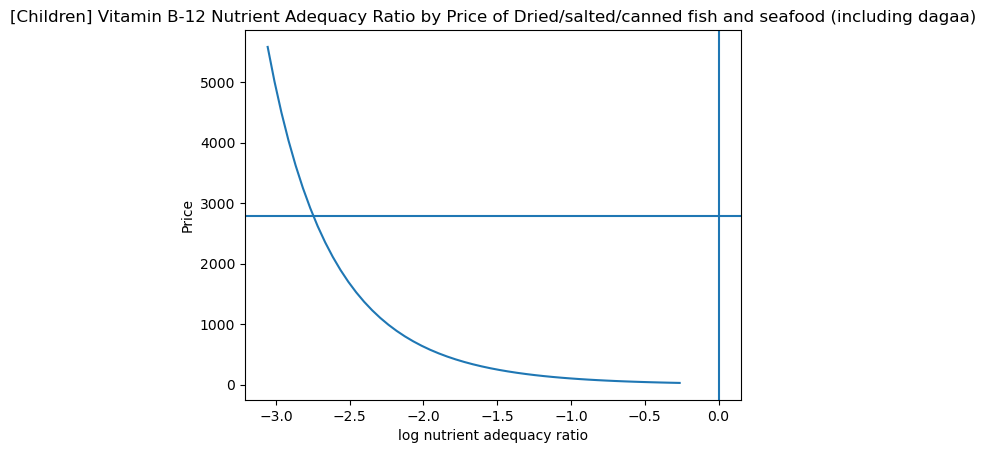

In [40]:
%matplotlib inline
scale = np.geomspace(.01,2,50)

USE_GOOD = 'Dried/salted/canned fish and seafood (including dagaa)'
ndf = pd.DataFrame({s*pbar_children[USE_GOOD]:np.log(nutrient_adequacy_ratio(r_children,xref_children/4,my_prices(pbar_children[USE_GOOD]*s,pbar_children,j=USE_GOOD),dbar_children))[UseNutrients] for s in scale}).T

fig,ax = plt.subplots()
ax.plot(ndf['Vitamin B-12'],ndf.index)
ax.axhline(pbar_children[USE_GOOD])
ax.axvline(0)

ax.set_ylabel('Price')
ax.set_xlabel('log nutrient adequacy ratio')
ax.set_title("[Children] Vitamin B-12 Nutrient Adequacy Ratio by Price of %s" % USE_GOOD)